# Mask Generation with OpenCV
In the paper they generate irregular masks by using occlusion/dis-occlusion between two consecutive frames of videos, as described in [this paper](https://lmb.informatik.uni-freiburg.de/Publications/2010/Bro10e/sundaram_eccv10.pdf). 

Instead we'll simply be using OpenCV to generate some irregular masks, which will hopefully perform just as well. We've implemented this in the function `_generate_mask`, which is located in the `util.py` file in the libs directory

In [1]:
import os, warnings
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2 as cv
import numpy as np

import tensorflow as tf
from keras.layers import Input, Dense, ZeroPadding2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.callbacks import LambdaCallback

if os.path.basename(os.getcwd()) != 'InsightProject':
    os.chdir('..')

from libs.util import random_mask
from libs.pconv_layer import PConv2D
from libs.pconv_model import PConvUnet

warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


Let's create some output samples with this function to see what it does

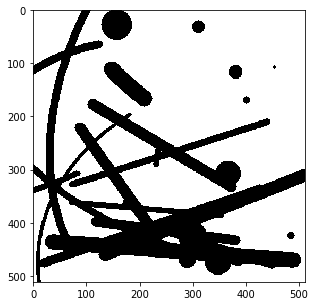

In [2]:
# Instantiate mask generator
mask = random_mask(512, 512, 3)#, rand_seed=42)

# Plot the results
_, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot image on axis
ax.imshow(mask*255);

Shape of image is: (512, 512, 3)


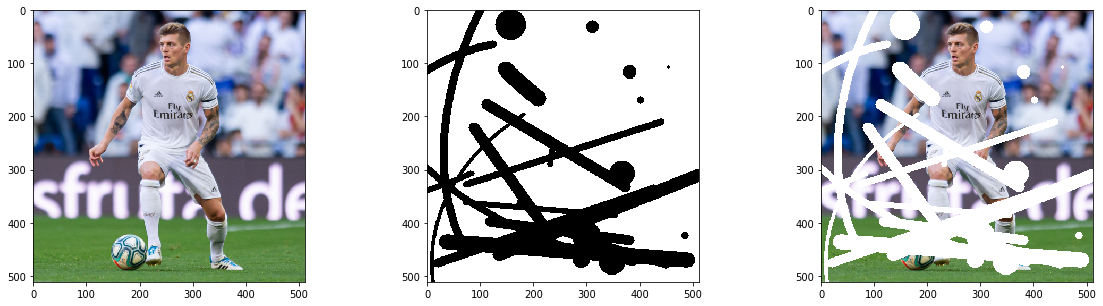

In [3]:
# Load image
img = cv.imread('data/inprinting-test-image.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, dsize=(512, 512), interpolation=cv.INTER_AREA)/255
img_size = img.shape
print(f"Shape of image is: {img_size}")

# Instantiate mask generator
height, width, channels = img.shape

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Plot
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

In [4]:
np.max(img), np.max(mask), np.max(masked_img)

(1.0, 1, 1.0)

# Implementing the Partial Convolution Layer

One of the pillars of the paper is the partial convolution layer, which we'll have to implement in Keras. We'll base the new layer off the current Convolution2D layer already in Keras, and then introduce the mask, so that in our PConv2D layer a tuple of (img, mask) is passed, and a tuple of (conv_img, conv_mask) is returned

In [5]:
def test_pconv(inp_shape) :
    inp_img = Input(shape=inp_shape)
    inp_msk = Input(shape=inp_shape)
    out_img, out_msk1 = PConv2D( 8, kernel_size=(7,7), strides=(2,2))([inp_img,  inp_msk])
    out_img, out_msk2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([out_img, out_msk1])
    out_img, out_msk3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([out_img, out_msk2])
    out_img, out_msk4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([out_img, out_msk3])
    out_img, out_msk5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([out_img, out_msk4])

    model = Model(inputs=[inp_img, inp_msk], 
                  outputs=[out_img, out_msk1, out_msk2, 
                           out_msk3, out_msk4, out_msk5])
    return model

pconv_model = test_pconv(img_size)
pconv_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
pconv_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'p_conv2d_1/Variable:0' shape=(7, 7, 3, 8) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_2/Variable:0' shape=(5, 5, 8, 16) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_3/Variable:0' shape=(5, 5, 16, 32) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_4/Variable:0' shape=(3, 3, 32, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_5/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 

In [6]:
formatted_img = np.expand_dims(masked_img, 0)
formatted_mask = np.expand_dims(mask, 0)
print(f"Mask Shape: {formatted_mask.shape}")
print(f"Max Mask Value: {np.max(formatted_mask)}")

out_img, out_msk1, out_msk2, out_msk3, out_msk4, \
         out_msk5 = pconv_model.predict([formatted_img, formatted_mask])

Mask Shape: (1, 512, 512, 3)
Max Mask Value: 1



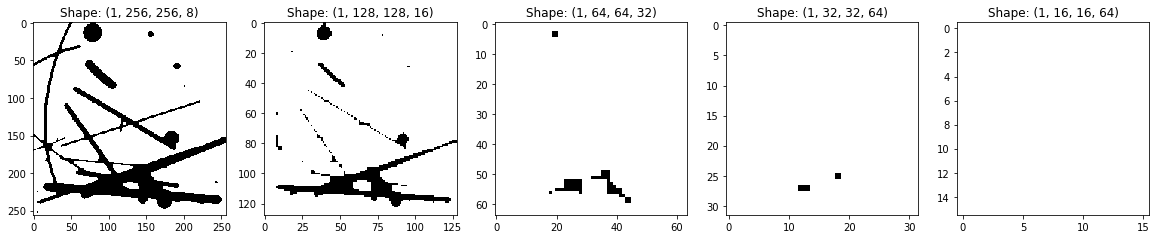

In [7]:
_, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(out_msk1[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0].set_title(f"Shape: {out_msk1.shape}")
axes[1].imshow(out_msk2[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1].set_title(f"Shape: {out_msk2.shape}")
axes[2].imshow(out_msk3[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[2].set_title(f"Shape: {out_msk3.shape}")
axes[3].imshow(out_msk4[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[3].set_title(f"Shape: {out_msk4.shape}")
axes[4].imshow(out_msk5[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[4].set_title(f"Shape: {out_msk5.shape}")
plt.show()

This looks exactly like it's supposed to - the further down we do in the network, the less significant the masking gets.

In [8]:
PConvUnet().summary()


tracking <tf.Variable 'p_conv2d_6/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_7/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_8/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_9/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_10/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_11/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_12/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_13/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_14/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_15/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_16/

In [9]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            orig = next(super().flow(x, *args, **kwargs))
            
            # Get masks for each image sample
            msk = np.stack([mask for _ in range(orig.shape[0])], axis=0)
            
            # Apply masks to all image sample
            masked = deepcopy(orig)
            masked[msk==0] = 1

            yield [masked, msk], orig        

# Create datagen
datagen = DataGenerator()

# Create generator from numpy array
BATCH_SIZE = 4
batch = np.stack([img for _ in range(BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=BATCH_SIZE)

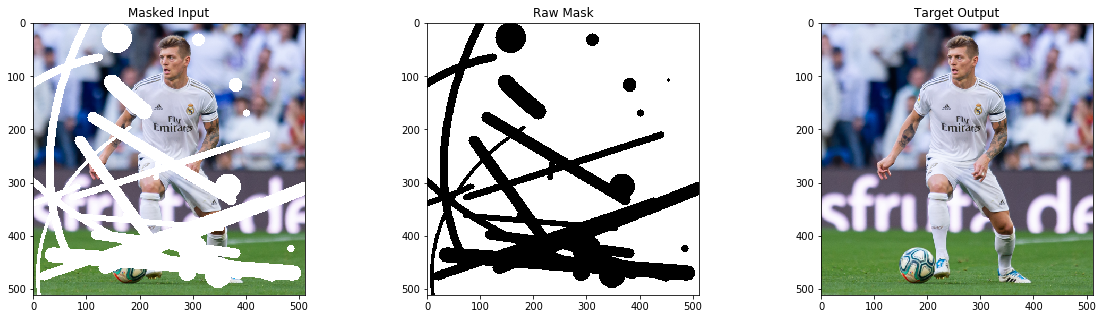

In [10]:
def plot_sample_data(masked, mask, ori):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title('Raw Mask')
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()

[m1, m2], o1 = next(generator)
plot_sample_data(m1[0], m2[0]*255, o1[0])

In [11]:
np.max(batch), np.max(mask), np.max(masked_img)

(1.0, 1, 1.0)

In [12]:
model = PConvUnet(vgg_weights='data/vgg16_weights.h5')

tracking <tf.Variable 'p_conv2d_22/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_23/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_24/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_25/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_26/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_27/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_28/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_29/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_30/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_31/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_

Epoch 1/1
2500/2500 [==============================] - 33759s 14s/step - loss: 1.4329 - PSNR: 17.9680


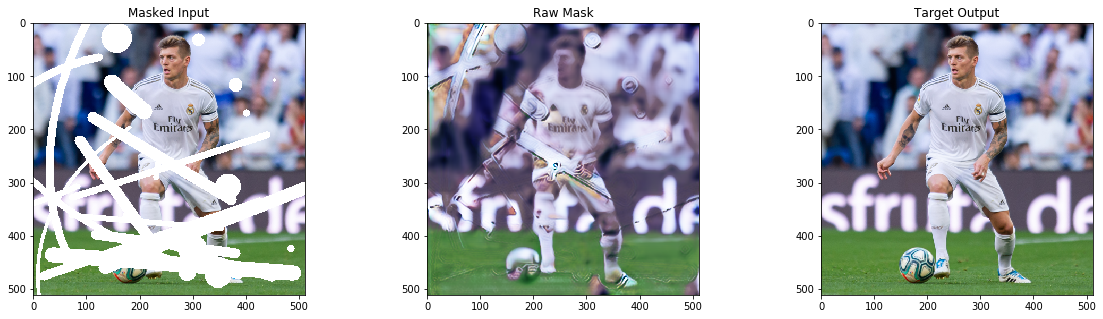

In [15]:
with tf.device('/cpu:0') :
    model.fit_generator(
    generator, 
    steps_per_epoch=2500,
    epochs=1,
    callbacks=[
        TensorBoard(
            log_dir='./data/single_image_test',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/single_image_test/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)
                    ]
                )[0], 
                img
            )
        )
    ],
)